## Imports

In [1]:
# Standard library imports
import os
import random
import pickle

# Data analysis packages
import numpy as np
import pandas as pd
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter1d

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrow, Patch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from matplotlib import gridspec

# Image processing packages
import imageio
from PIL import Image, ImageSequence

# Braingeneers packages for analysis
import braingeneers
import braingeneers.data.datasets_electrophysiology as ephys
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster

## Helper Functions

In [2]:
# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)

def plot_raster(sd, title):
    idces, times = sd.idces_times()
    # Adjust the figsize parameter to change the figure size; (width, height) in inches
    fig, ax = plt.subplots(figsize=(10, 6))  # Example: 10 inches wide by 6 inches tall

    ax.scatter(times/1000, idces, marker='|', s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax.set_title(title)
    plt.show()

def load_from_pickle(file_path):
    """
    Load and return the Python object from a pickle file.
    
    Parameters:
    - file_path: str, the path to the pickle file to be loaded.
    
    Returns:
    - The Python object loaded from the pickle file.
    """
    try:
        with open(file_path, 'rb') as file:
            return pickle.load(file)
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
    except Exception as e:
        print(f"An error occurred while loading the pickle file: {e}")

## Plotting Function

In [3]:
# def firing_plotter_with_raster(sd, global_min_rate, global_max_rate, time_windows):
#     # Define your colors and colormap for the firing rate plots
#     colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
#     cmap_name = "custom_red_black"
#     n_bins = 100
#     cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    
#     # Window colors for the raster plot shading
#     window_colors = ['#ffcccb', '#add8e6', '#77dd77', '#ffd700', '#fdbcb4']

#     # Adjust figure size and GridSpec layout
#     fig = plt.figure(figsize=(14, 6))
#     gs = gridspec.GridSpec(2, 5, width_ratios=[1, 1, 1, 1, 0.05], height_ratios=[1, 0.8])
#     fig.suptitle("Firing Rate by Time Window", fontsize=18)

#     # Loop through time windows and plot firing rates
#     for i, (start_time, end_time) in enumerate(time_windows):
#         ax = plt.subplot(gs[0, i])
#         current_sd = sd.subtime(start_time * 1000, end_time * 1000)  # Convert milliseconds to seconds
#         firing_rates = calculate_mean_firing_rates(current_sd)  # Assuming this is a function you have
#         neuron_x, neuron_y = [], []

#         for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists
#             neuron_x.append(neuron['position'][0])
#             neuron_y.append(neuron['position'][1])

#         scatter = ax.scatter(neuron_x, neuron_y, s=firing_rates*10, c=firing_rates, cmap=cm, vmin=global_min_rate, vmax=global_max_rate, alpha=0.6)

#         # Update titles and labels to reflect seconds
#         ax.set_title(f"{start_time}s to {end_time}s", fontsize=18)
#         ax.set_xlabel("X Position", fontsize=14)
#         ax.set_ylabel("Y Position", fontsize=14)
#         ax.tick_params(axis='both', which='major', labelsize=12)

#         ax.set_aspect('equal')
#         ax.invert_yaxis()

#     # Determine the overall min and max times for the raster plot, in seconds
#     overall_min_time = min(start for start, _ in time_windows)
#     overall_max_time = max(end for _, end in time_windows)

#     # Add the raster plot beneath the subplots
#     ax_raster = plt.subplot(gs[1, :-1])
#     idces, times = sd.idces_times()  # Assuming this method exists within the sd object
#     ax_raster.scatter(times/1000, idces, marker='|', s=1)
#     ax_raster.set_xlabel("Time (seconds)", fontsize=14)
#     ax_raster.set_ylabel('Unit #', fontsize=14)
#     ax_raster.set_title("Raster Plot", fontsize=18)
#     ax_raster.tick_params(axis='both', which='major', labelsize=12)

#     ax_raster.set_xlim(overall_min_time, overall_max_time)

#     # Shade each time window section on the raster plot with different colors
#     for i, (start_time, end_time) in enumerate(time_windows):
#         color = window_colors[i % len(window_colors)]
#         ax_raster.axvspan(start_time, end_time, color=color, alpha=0.3)

#     # Setup colorbar axis to match only the height of the firing rate plots
#     cbar_ax = fig.add_subplot(gs[0, -1])
#     cbar = fig.colorbar(scatter, cax=cbar_ax, label='Firing Rate (Hz)')
#     cbar.set_label('Firing Rate (Hz)', size=14)
#     cbar.ax.tick_params(labelsize=12)

#     plt.tight_layout()
#     plt.show()

def firing_plotter_with_raster(sd, global_min_rate, global_max_rate, time_windows):
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    # Define your colors and colormap for the firing rate plots
    colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
    cmap_name = "custom_red_black"
    n_bins = 100
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    
    # Window colors for the raster plot shading
    window_colors = ['#ffcccb', '#add8e6', '#77dd77', '#ffd700', '#fdbcb4']

    # Adjust figure size and GridSpec layout to accommodate the new raster plot
    fig = plt.figure(figsize=(14, 10))  # Increased figure height
    gs = gridspec.GridSpec(3, 5, width_ratios=[1, 1, 1, 1, 0.05], height_ratios=[1, 0.8, 0.8])  # Added another row for the raster plot
    fig.suptitle("Firing Rate by Time Window", fontsize=18)

    # Loop through time windows and plot firing rates
    for i, (start_time, end_time) in enumerate(time_windows):
        ax = plt.subplot(gs[0, i])
        current_sd = sd.subtime(start_time * 1000, end_time * 1000)  # Convert milliseconds to seconds
        firing_rates = calculate_mean_firing_rates(current_sd)  # Assuming this is a function you have
        neuron_x, neuron_y = [], []

        for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists
            neuron_x.append(neuron['position'][0])
            neuron_y.append(neuron['position'][1])

        scatter = ax.scatter(neuron_x, neuron_y, s=firing_rates*1.5, c=firing_rates, cmap=cm, vmin=global_min_rate, vmax=global_max_rate, alpha=0.6)

        # Update titles and labels to reflect seconds
        ax.set_title(f"{start_time}s to {end_time}s", fontsize=18)
        ax.set_xlabel("X Position", fontsize=14)
        if i == 0:  # Only the first plot gets Y axis labels
            ax.set_ylabel("Y Position", fontsize=14)
        else:
            ax.set_yticklabels([])  # Remove y tick labels for other plots
        
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_aspect('equal')
        ax.invert_yaxis()
        # ax.patch.set_edgecolor(window_colors[i % len(window_colors)])  # Set edge color
        # ax.patch.set_linewidth(4)  
        bottom_border_color = window_colors[i % len(window_colors)]  # Use the same color logic
        ax.axhline(y=ax.get_ylim()[0], color=bottom_border_color, linewidth=7)  # Draw the line at the bottom

    # Determine the overall min and max times for the raster plot, in seconds
    overall_min_time = min(start for start, _ in time_windows)
    overall_max_time = max(end for _, end in time_windows)

    # Add the first raster plot beneath the subplots
    ax_raster = plt.subplot(gs[1, :-1])
    idces, times = sd.idces_times()  # Assuming this method exists within the sd object
    ax_raster.scatter(times/1000, idces, marker='|', s=1)
    ax_raster.set_xlabel("Time (seconds)", fontsize=14)
    ax_raster.set_ylabel('Unit #', fontsize=14)
    ax_raster.set_title("Zoomed Raster Plot", fontsize=18)
    ax_raster.tick_params(axis='both', which='major', labelsize=12)

    ax_raster.set_xlim(overall_min_time, overall_max_time)

    # Shade each time window section on the first raster plot with different colors
    for i, (start_time, end_time) in enumerate(time_windows):
        color = window_colors[i % len(window_colors)]
        ax_raster.axvspan(start_time, end_time, color=color, alpha=0.3)

    # Add the second raster plot (full spikedata)
    ax_raster_full = plt.subplot(gs[2, :-1])
    ax_raster_full.scatter(times/1000, idces, marker='|', s=1)
    ax_raster_full.set_xlim(0, sd.length / 1000)  # Assuming length is in milliseconds
    ax_raster_full.set_xlabel("Time (seconds)", fontsize=14)
    ax_raster_full.set_ylabel('Unit #', fontsize=14)
    ax_raster_full.set_title("Full Raster Plot", fontsize=18)
    ax_raster_full.tick_params(axis='both', which='major', labelsize=12)

    # Shade each time window section on the second raster plot with different colors
    for i, (start_time, end_time) in enumerate(time_windows):
        color = window_colors[i % len(window_colors)]
        ax_raster_full.axvspan(start_time, end_time, color=color, alpha=0.3)

    # Setup colorbar axis to match only the height of the top row of firing rate plots
    cbar_ax = plt.subplot(gs[0, -1])
    cbar = fig.colorbar(scatter, cax=cbar_ax, label='Firing Rate (Hz)')
    cbar.set_label('Firing Rate (Hz)', size=14)
    cbar.ax.tick_params(labelsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout to prevent the title from being cut off
    plt.show()

## Data

In [45]:
random_spike_data = load_from_pickle('data/random_spike_data.pkl')
circular_spike_data = load_from_pickle('data/circle_overlap_spike_data.pkl')
linear_spike_data = load_from_pickle('data/linear_overlap_spike_data.pkl')
loop_spike_data = load_from_pickle('data/loop_overlap_spike_data.pkl')
continuous_loop_spike_data = load_from_pickle('data/continuous_loop_overlap_spike_data.pkl')
spiral_wave_spike_data = load_from_pickle('data/spiral_wave_spike_data.pkl')

## Plots

/tmp/ipykernel_64541/1643876493.py:93: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists
/tmp/ipykernel_64541/1643876493.py:93: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists
/tmp/ipykernel_64541/1643876493.py:93: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists


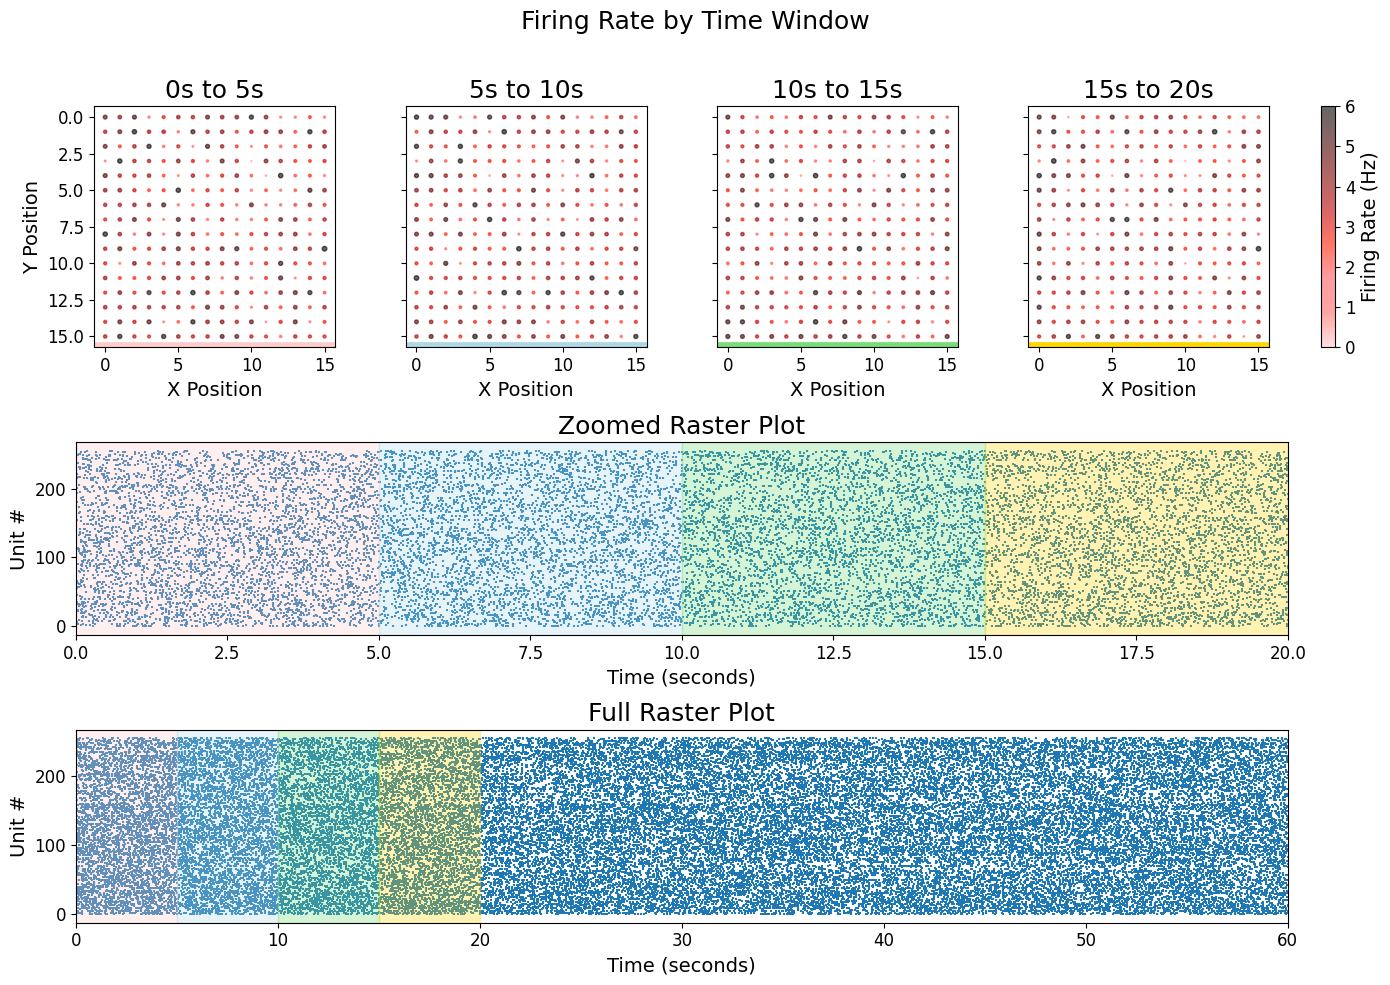

In [67]:
firing_plotter_with_raster(random_spike_data, 0, 6, [(0, 5), (5, 10), (10, 15), (15, 20)])

/tmp/ipykernel_64541/1643876493.py:93: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists
/tmp/ipykernel_64541/1643876493.py:93: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists
/tmp/ipykernel_64541/1643876493.py:93: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists


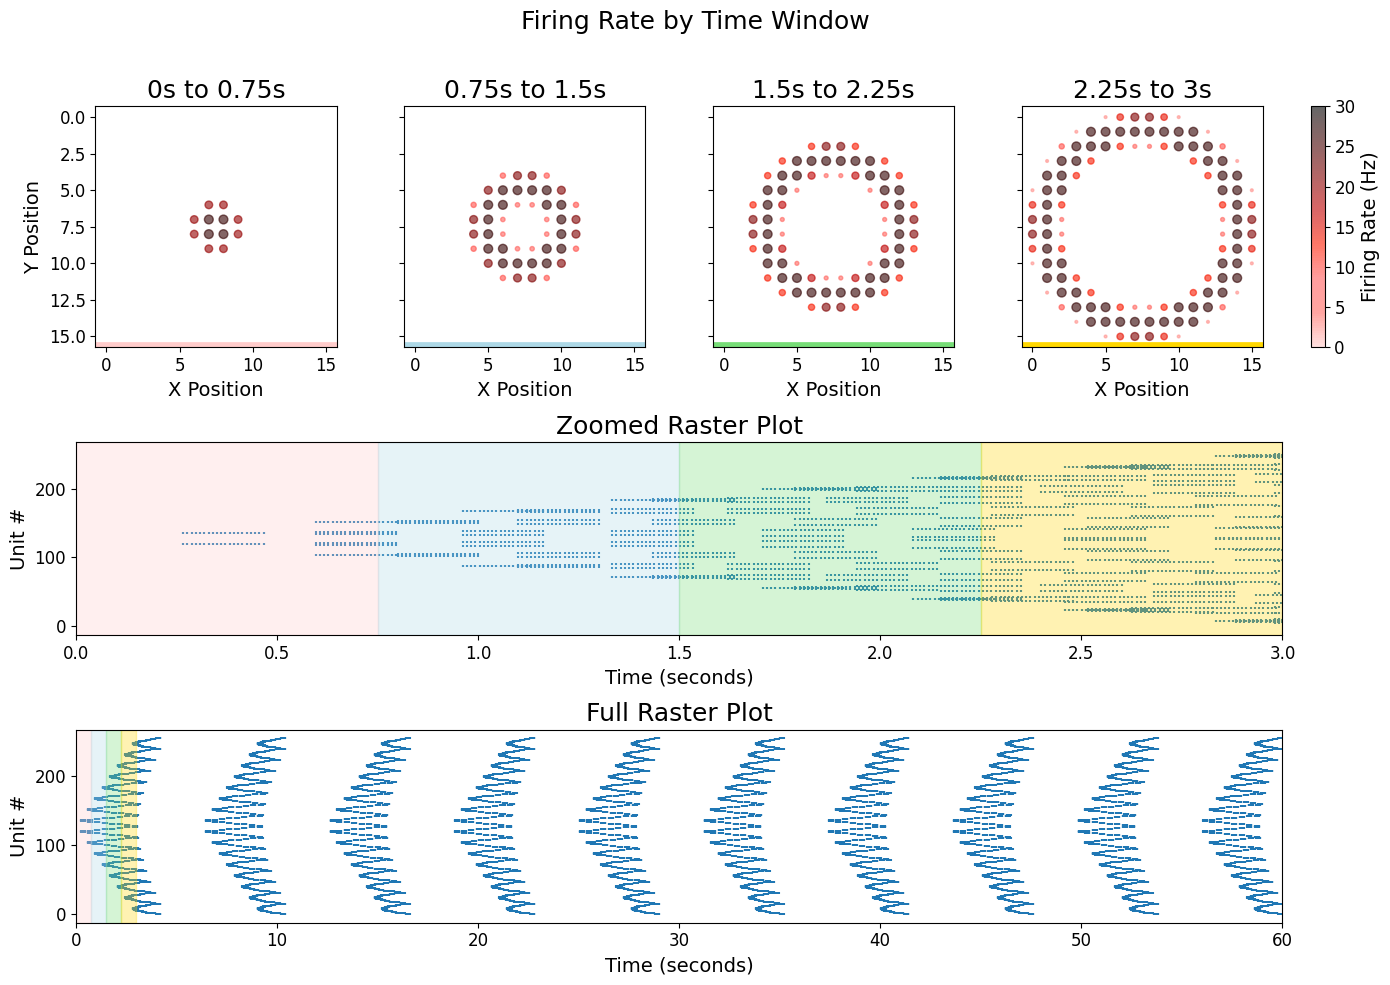

In [63]:
firing_plotter_with_raster(circular_spike_data, 0, 30, [(0, 0.75), (0.75, 1.5), (1.5, 2.25), (2.25, 3)])

/tmp/ipykernel_64541/1643876493.py:93: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists
/tmp/ipykernel_64541/1643876493.py:93: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists
/tmp/ipykernel_64541/1643876493.py:93: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists


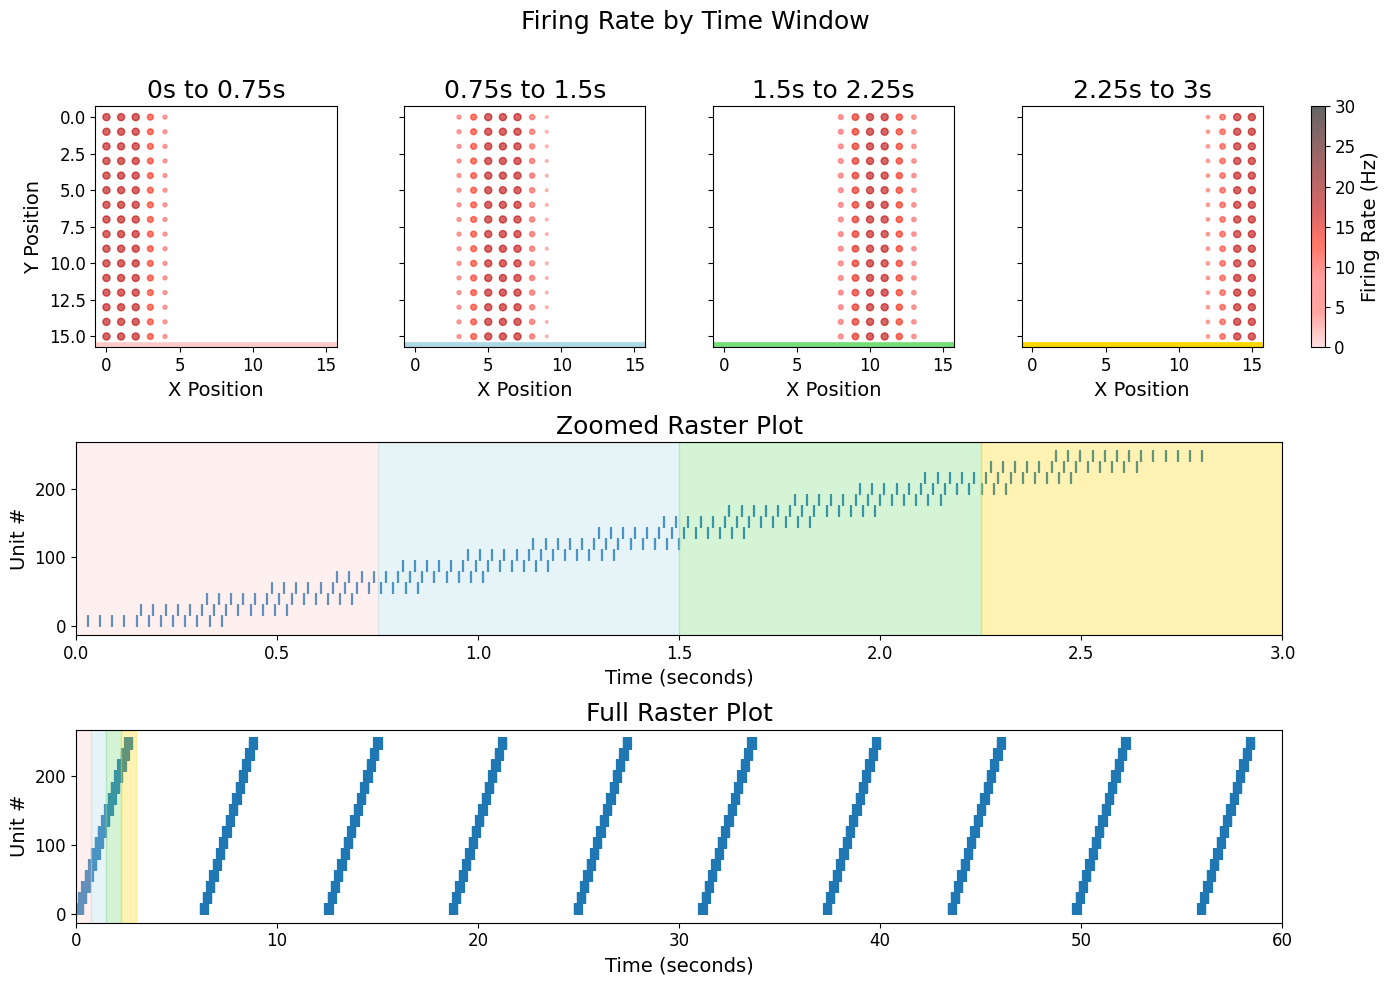

In [72]:
firing_plotter_with_raster(linear_spike_data, 0, 30, [(0, 0.75), (0.75, 1.5), (1.5, 2.25), (2.25, 3)])

/tmp/ipykernel_2200/1643876493.py:93: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists
/tmp/ipykernel_2200/1643876493.py:93: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists
/tmp/ipykernel_2200/1643876493.py:93: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists


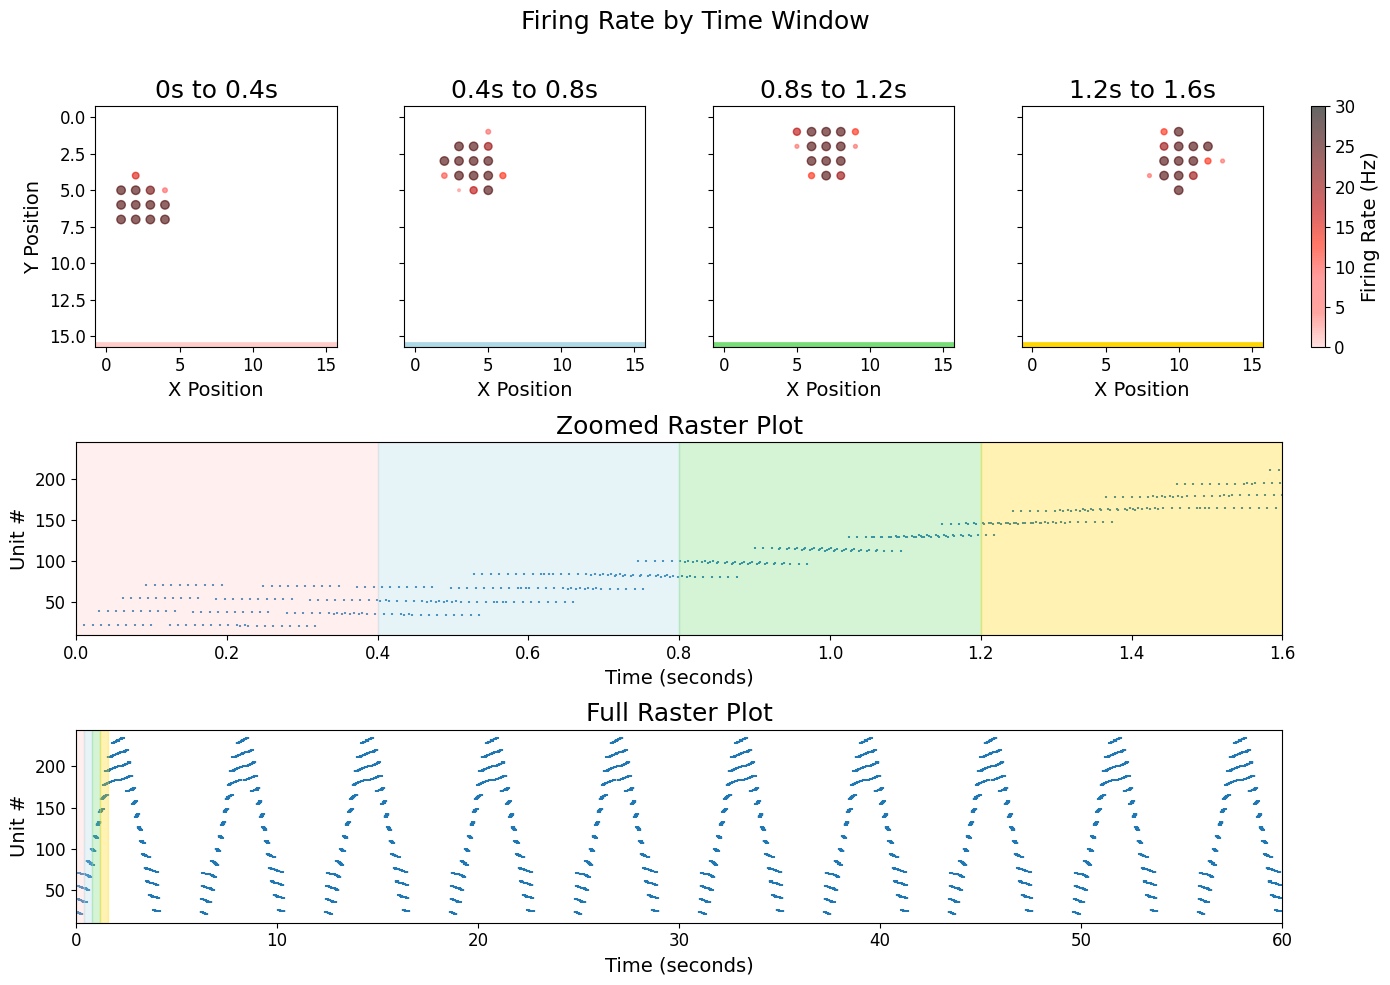

In [23]:
firing_plotter_with_raster(loop_spike_data, 0, 30, [(0, 0.4), (0.4, 0.8), (0.8, 1.2), (1.2, 1.6)])

/tmp/ipykernel_2200/1643876493.py:93: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists
/tmp/ipykernel_2200/1643876493.py:93: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists
/tmp/ipykernel_2200/1643876493.py:93: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists


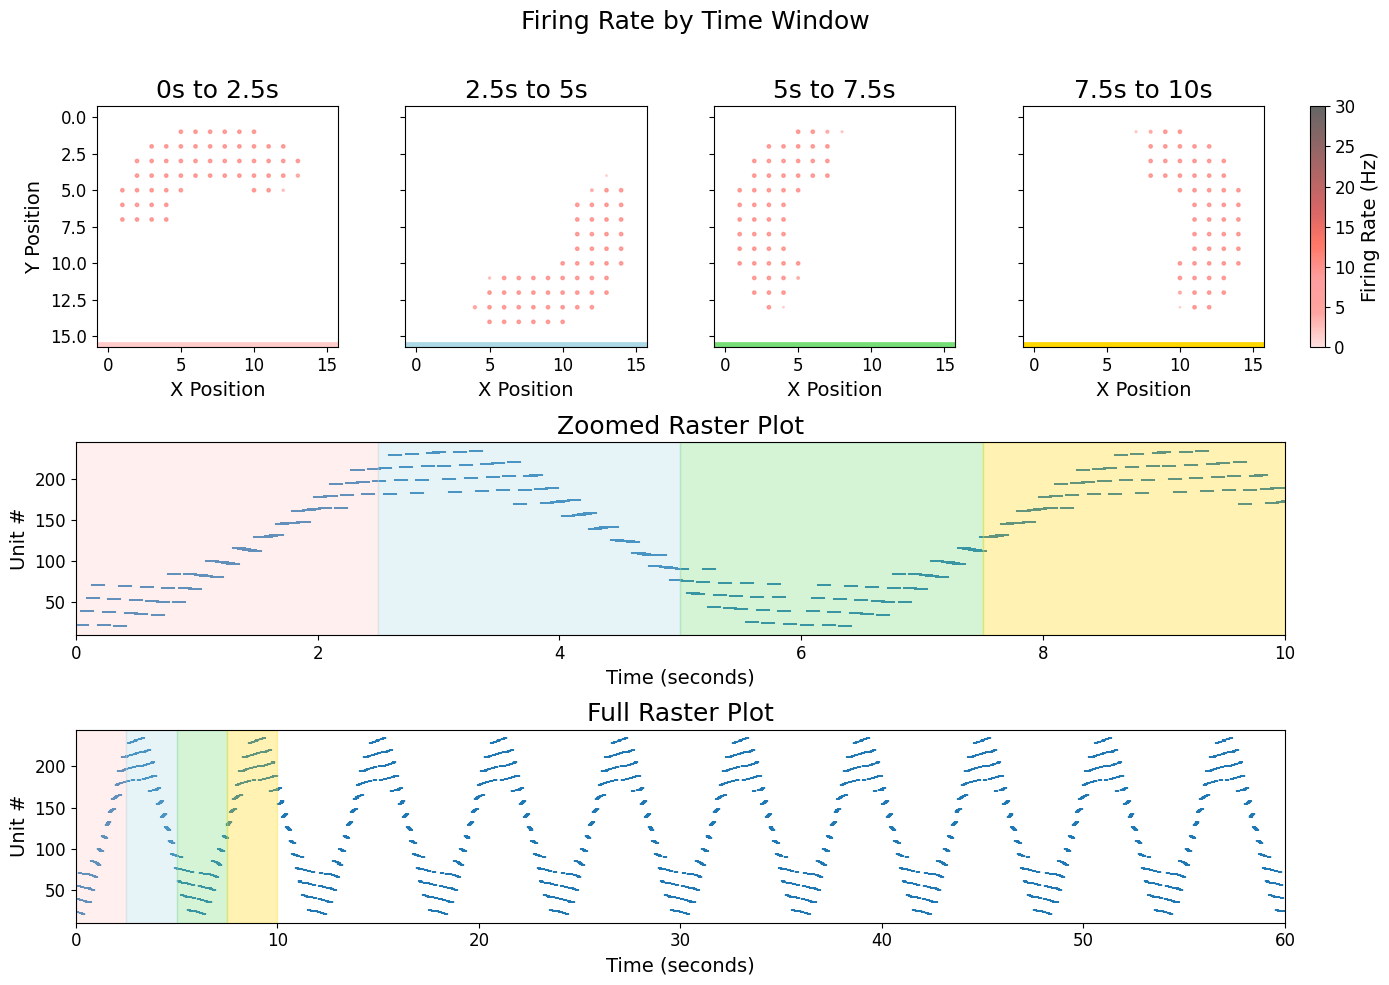

In [26]:
firing_plotter_with_raster(continuous_loop_spike_data, 0, 30, [(0, 2.5), (2.5, 5), (5, 7.5), (7.5, 10)])

/tmp/ipykernel_2200/1643876493.py:93: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists
/tmp/ipykernel_2200/1643876493.py:93: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists
/tmp/ipykernel_2200/1643876493.py:93: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists


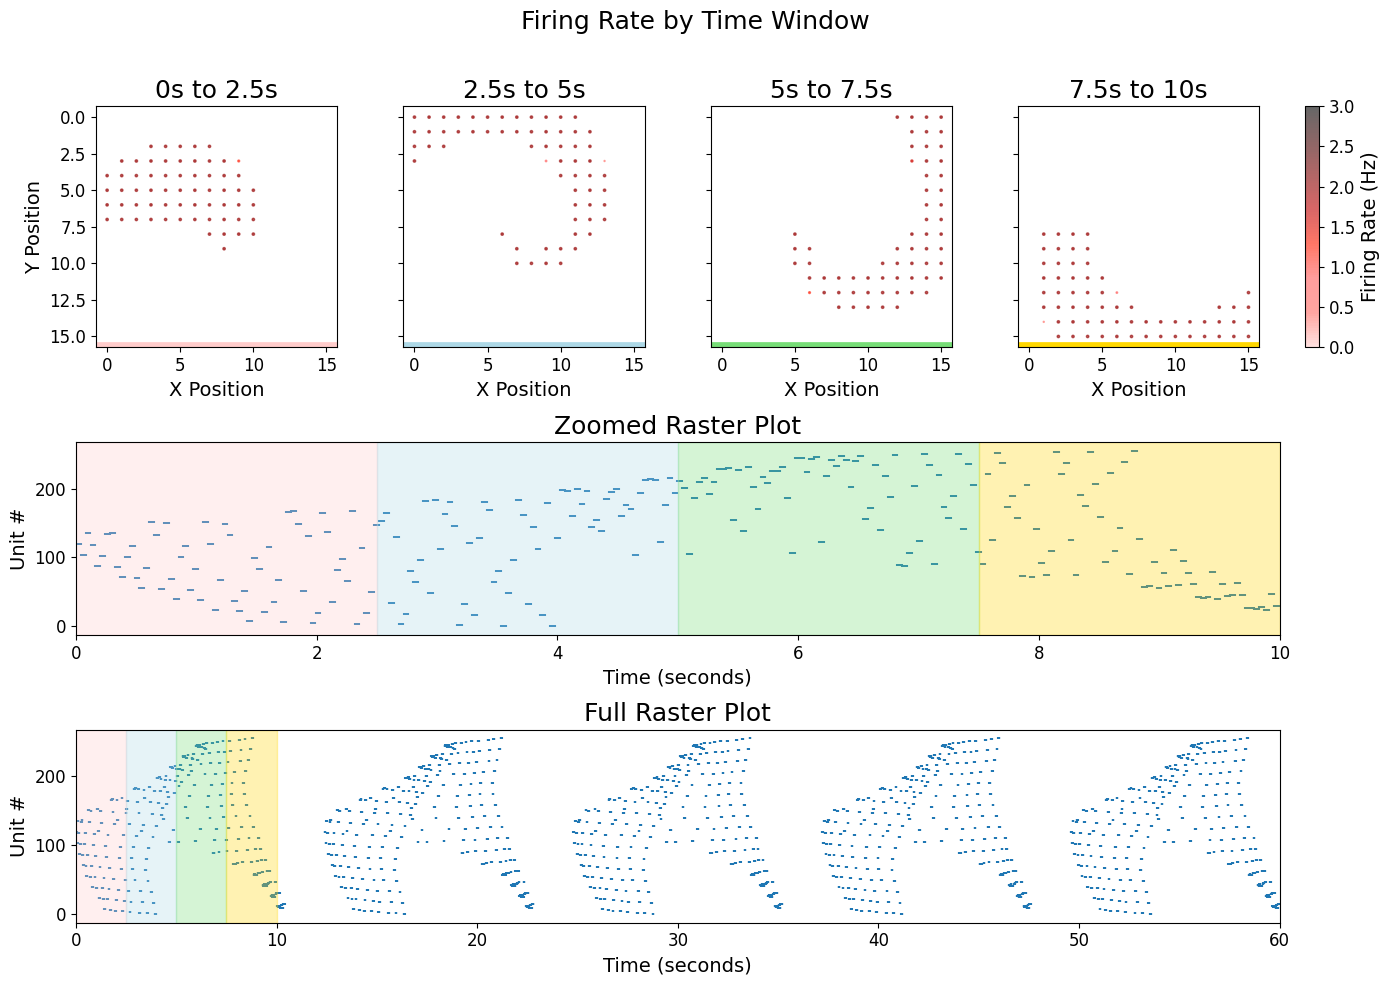

In [52]:
firing_plotter_with_raster(spiral_wave_spike_data, 0, 3, [(0, 2.5), (2.5, 5), (5, 7.5), (7.5, 10)])